In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("Medical_charges.csv")
print(df)
df.info()

      age     sex     bmi  children smoker     region      charges
0      19  female  27.900         0    yes  southwest  16884.92400
1      18    male  33.770         1     no  southeast   1725.55230
2      28    male  33.000         3     no  southeast   4449.46200
3      33    male  22.705         0     no  northwest  21984.47061
4      32    male  28.880         0     no  northwest   3866.85520
...   ...     ...     ...       ...    ...        ...          ...
1333   50    male  30.970         3     no  northwest  10600.54830
1334   18  female  31.920         0     no  northeast   2205.98080
1335   18  female  36.850         0     no  southeast   1629.83350
1336   21  female  25.800         0     no  southwest   2007.94500
1337   61  female  29.070         0    yes  northwest  29141.36030

[1338 rows x 7 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    -----------

smoker
no     1064
yes     274
Name: count, dtype: int64
region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64
sex
male      676
female    662
Name: count, dtype: int64


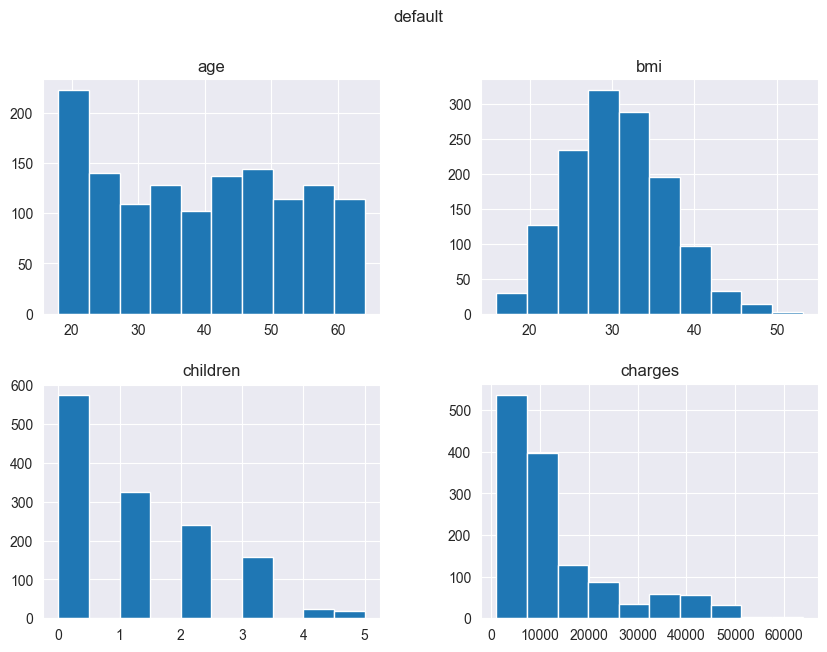

In [37]:
print(df["smoker"].value_counts())
print(df["region"].value_counts())
print(df["sex"].value_counts())

df.hist(figsize=(10,7))
plt.suptitle("default")
plt.show()

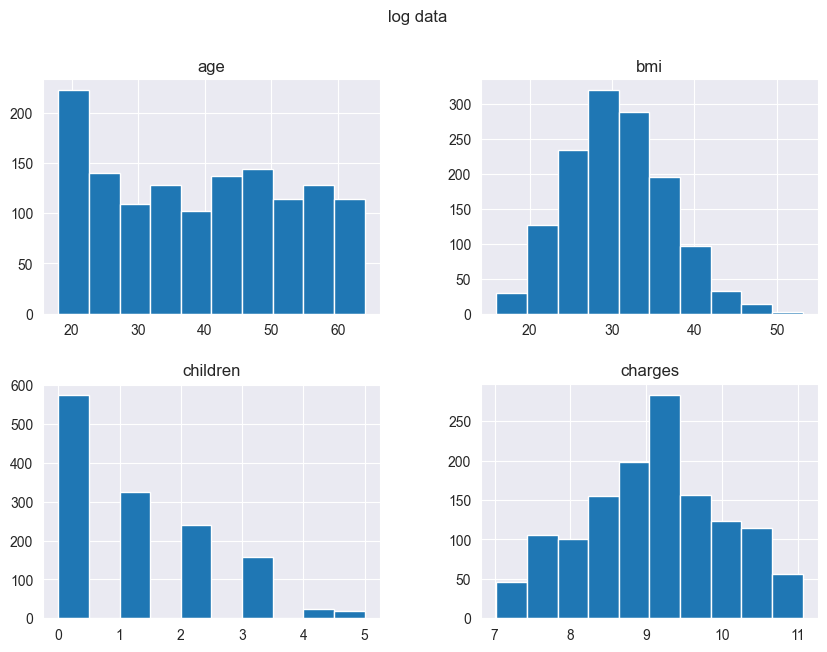

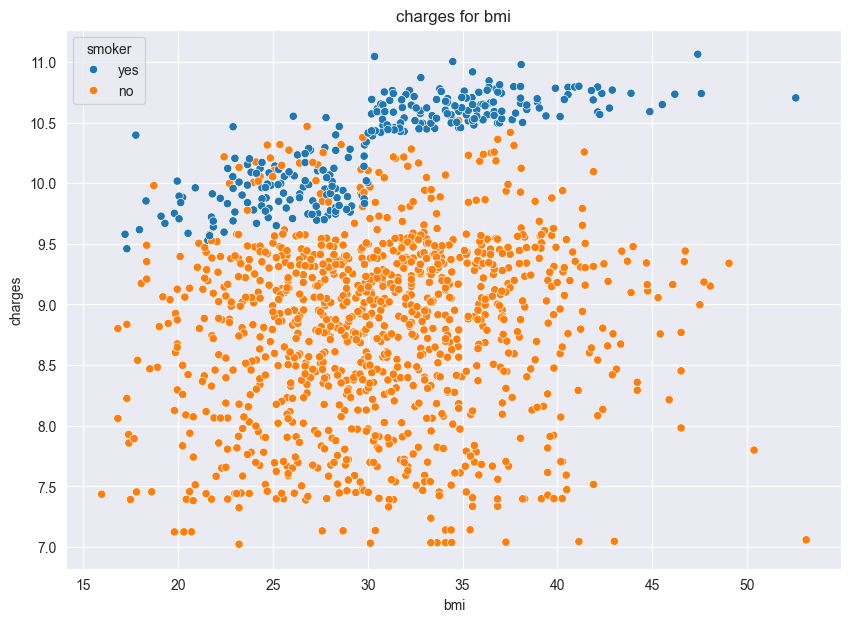

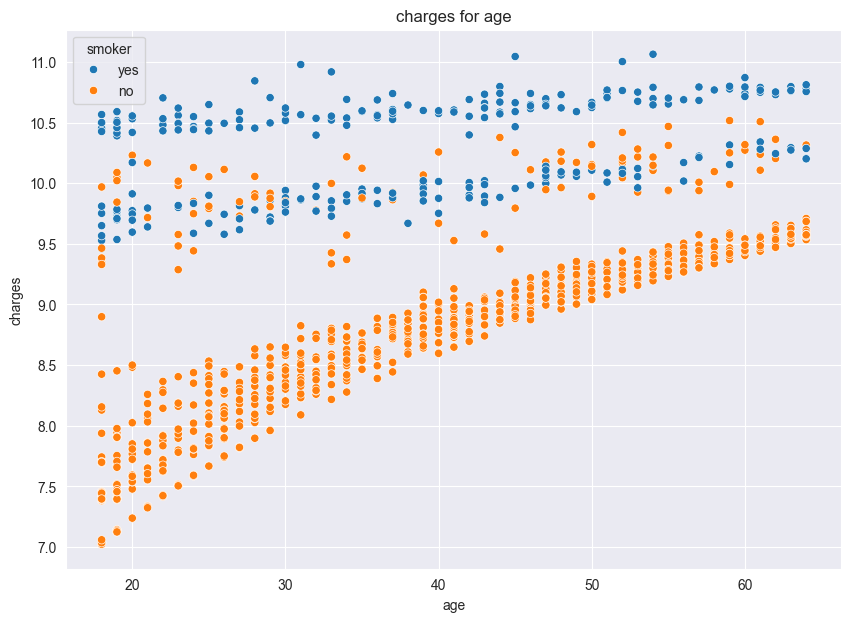

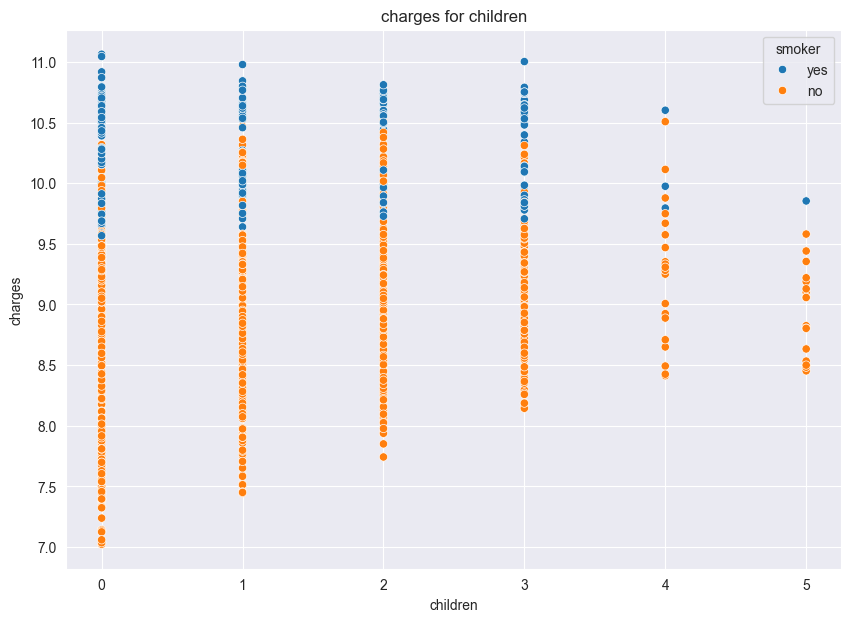

In [38]:

test_df = df.copy()
# test_df["bmi"] = np.log1p(test_df["bmi"])
test_df["charges"] = np.log1p(test_df["charges"])

test_df.hist(figsize=(10,7))
plt.suptitle("log data")
plt.show()

plt.figure(figsize=(10,7))
sns.scatterplot(x=test_df["bmi"], y=test_df["charges"], hue=test_df["smoker"])
plt.title("charges for bmi")
plt.show()

plt.figure(figsize=(10,7))
sns.scatterplot(x=test_df["age"], y=test_df["charges"], hue=test_df["smoker"])
plt.title("charges for age")
plt.show()

plt.figure(figsize=(10,7))
sns.scatterplot(x=test_df["children"], y=test_df["charges"], hue=test_df["smoker"])
plt.title("charges for children")
plt.show()


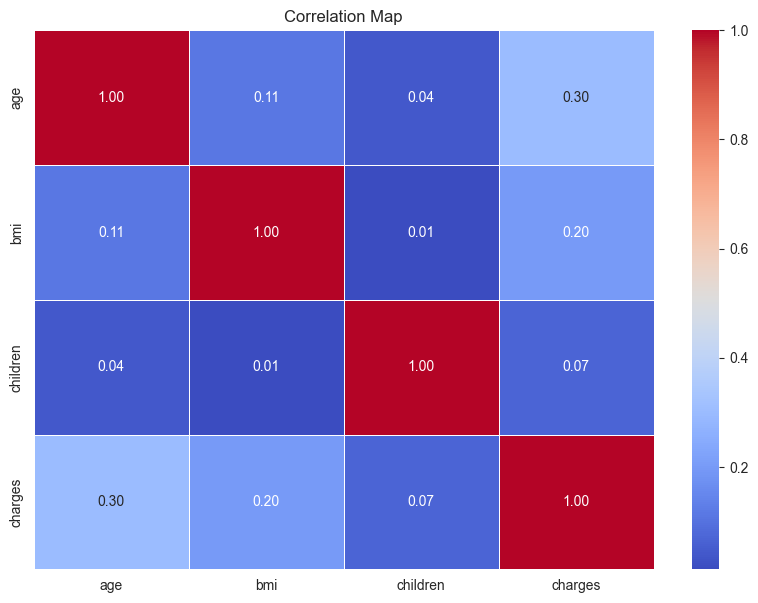

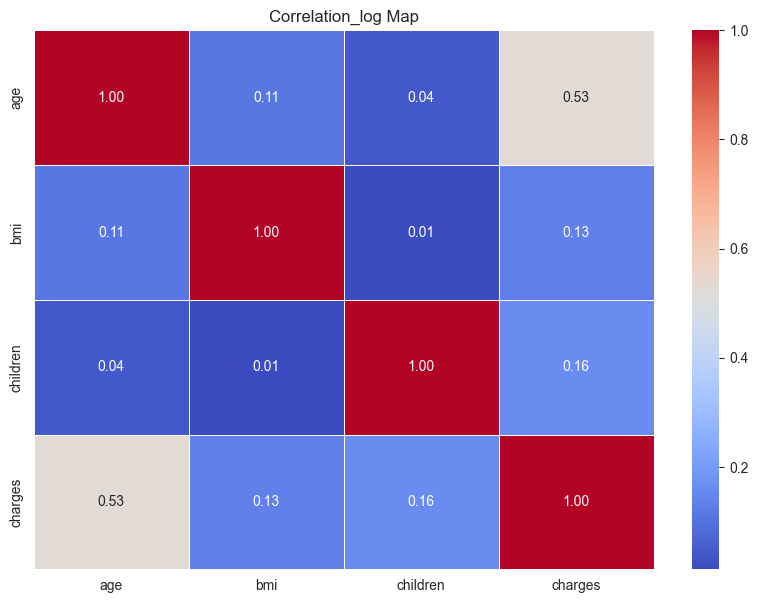

In [39]:
corr = df.corr(numeric_only=True)
corr_log = test_df.corr(numeric_only=True)
plt.figure(figsize=(10,7))

sns.heatmap(corr, annot=True, fmt = ".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Map")
plt.show()

plt.figure(figsize=(10,7))
sns.heatmap(corr_log, annot=True, fmt = ".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation_log Map")
plt.show()



In [40]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor


X = df.drop(["charges"], axis=1)
y = df["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

objects = X_train.select_dtypes(["object"]).columns.to_list()
integers = X_train.select_dtypes(["int", "float64"]).columns.to_list()


preprocess = ColumnTransformer(
    transformers= [
        ("obj", OneHotEncoder(handle_unknown="ignore"), objects),
        ("int", "passthrough", integers)
    ]
)
models_selection = {
    "linear": LinearRegression(n_jobs= -1),
    "randomforest": RandomForestRegressor(n_jobs= -1,random_state=42),
    "gradientboost": HistGradientBoostingRegressor(random_state=42),
    "kneib": KNeighborsRegressor(n_jobs= -1),
    "treedecision": DecisionTreeRegressor(random_state=42)
}



best_model = None
best_score = 0
min_std = 0.05
gap = 0
for name, model in models_selection.items():
    pipe = Pipeline(
        [
            ("prepross", preprocess),
            ("model", model)
        ]
    )

    cv = cross_validate(pipe, X_train,y_train, cv= 5, scoring="r2", return_train_score=True)
    print(f"Test with {name}")
    print(cv["train_score"])
    print(f"cross-validation score: {cv["test_score"]}")
    print(f"cross-validation std: {np.std(cv["test_score"])}")
    print(f"cross-validation mean: {np.mean(cv["test_score"])}")
    gap_count =(np.mean(cv["train_score"]) - np.mean(cv["test_score"]))
    print(f"Model Gap: {gap_count}")

    if np.mean(cv["test_score"]) > best_score and np.std(cv["test_score"]) <= min_std:
        best_model = model
        best_score = np.mean(cv["test_score"])
        gap = gap_count
print(f"Model with the highest cv score: {best_model}, gap is {gap:.3f}")



Test with linear
[0.74762013 0.72260804 0.7445171  0.76058033 0.73450496]
cross-validation score: [0.71585461 0.80210564 0.72296123 0.65784333 0.76678575]
cross-validation std: 0.048908631587897676
cross-validation mean: 0.733110110909758
Model Gap: 0.008855999031367245
Test with randomforest
[0.97632966 0.97146586 0.97643061 0.9777539  0.97387286]
cross-validation score: [0.82006138 0.89969724 0.79723229 0.78561791 0.83498476]
cross-validation std: 0.039985092123743696
cross-validation mean: 0.8275187141367251
Model Gap: 0.14765186477982084
Test with gradientboost
[0.94729591 0.93880484 0.94842762 0.95360194 0.94669018]
cross-validation score: [0.81718161 0.89831912 0.77564288 0.7787907  0.83791667]
cross-validation std: 0.04498058926965872
cross-validation mean: 0.8215701964553684
Model Gap: 0.1253939028461296
Test with kneib
[0.49192739 0.46226401 0.47660014 0.49686597 0.51090572]
cross-validation score: [0.18866786 0.30207938 0.26440339 0.14875783 0.14252508]
cross-validation std: 

In [41]:

pipe = Pipeline(
    [
        ("prepross", preprocess),
        ("model", best_model)
    ]
)
y_shuffled = np.random.permutation(y_train)

cv_score = cross_validate(
    pipe,
    X_train,
    y_shuffled,
    scoring='r2',
    cv=3
)
print(f"Shuffled cv-score: {np.mean(cv_score['test_score'])}")

param_grid = {
    "model__n_estimators" : [100, 200, 300],
    "model__max_depth" : [None,2,5,10],
    "model__min_samples_split" : [2,4,6],
    "model__max_samples": [None,1,2]
}

grid = GridSearchCV(pipe,param_grid,cv=3, scoring="r2")
grid.fit(X_train, y_train)

Shuffled cv-score: -0.18013745852676935


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'model__max_depth': [None, 2, ...], 'model__max_samples': [None, 1, ...], 'model__min_samples_split': [2, 4, ...], 'model__n_estimators': [100, 200, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'r2'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computatio

In [42]:
print(grid.best_params_)
print(grid.best_index_)
print(grid.best_score_)
print(grid.best_estimator_)

{'model__max_depth': 5, 'model__max_samples': None, 'model__min_samples_split': 6, 'model__n_estimators': 200}
61
0.8465646712238897
Pipeline(steps=[('prepross',
                 ColumnTransformer(transformers=[('obj',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sex', 'smoker', 'region']),
                                                 ('int', 'passthrough',
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('model',
                 RandomForestRegressor(max_depth=5, min_samples_split=6,
                                       n_estimators=200, n_jobs=-1,
                                       random_state=42))])


In [43]:
best_mdl = grid.best_estimator_
best_mdl.score(X_test,y_test)

0.8737417411975549

MAE: 2551.9431802774448
MSE: 19601434.519439656
RMSE: 4427.3507337277515


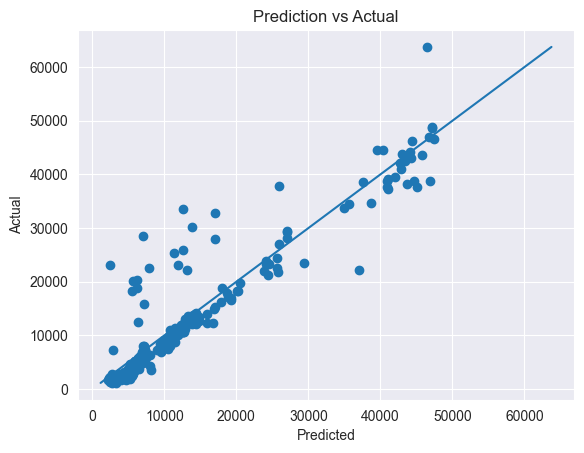

In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

prediction = best_mdl.predict(X_test)

print(f"MAE: {mean_absolute_error(y_test, prediction)}")
print(f"MSE: {mean_squared_error(y_test, prediction)}")
print(f"RMSE: {math.sqrt(mean_squared_error(y_test, prediction))}")

plt.scatter(prediction, y_test)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Prediction vs Actual")
plt.show()

In [45]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    best_mdl,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring="neg_mean_absolute_error"
)

importances = pd.DataFrame({
    "feature": X_test.columns,
    "importance": abs(-result.importances_mean)
}).sort_values("importance", ascending=False)

print(importances)

    feature   importance
4    smoker  6790.363498
0       age  2687.397201
2       bmi  1661.263896
3  children   219.577421
5    region    24.960049
1       sex     2.837127
